In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance, linspace_2D_equidistant
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.set_default_dtype(torch.float32)

In [2]:
from inxss.experiment import NeutronExperiment

In [3]:
data = torch.load('/pscratch/sd/z/zhantao/inxs_steering/experiment_data/summarized_neutron_data_260meV.pt')
print(data.keys())

dict_keys(['grid', 'S'])


### setup experiment simulator

In [4]:
neutron_exp = NeutronExperiment(tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), data['grid']['w_grid'], data['S'])
hklw_grid = torch.moveaxis(
            torch.stack(torch.meshgrid(neutron_exp.h_grid, neutron_exp.k_grid, neutron_exp.l_grid, neutron_exp.w_grid, indexing='ij'), dim=0), 0, -1)
neutron_exp.prepare_experiment(hklw_grid)

### setup neural network model

In [5]:
model = SpecNeuralRepr.load_from_checkpoint(
    '/pscratch/sd/z/zhantao/inxs_steering/lightning_logs/version_14896843/checkpoints/epoch=1165-step=55968.ckpt'
    ).to(device)

In [6]:
# sqw_disp = neutron_exp.Sqw.sum(-1).sum(-1)
sqw_disp = neutron_exp.Sqw.sum(-1).sum(-1) / (neutron_exp.Sqw > 1).sum(-1).sum(-1)
# sqw_disp = data['S'].sum(-1).sum(-1) / (data['S'] > 1e-3).sum(-1).sum(-1)

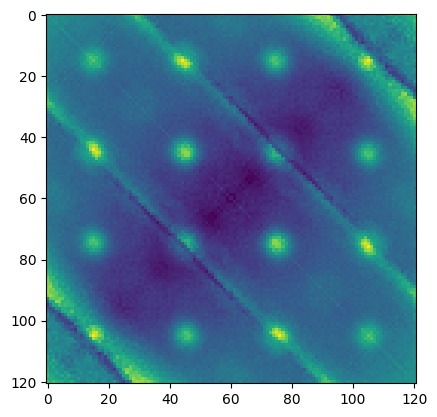

In [7]:
plt.imshow(sqw_disp)

In [8]:
x_input = torch.zeros(hklw_grid.shape[:-1]+(5,))

x_input[...,:3] = hklw_grid[...,[0,1,3]]
x_input[...,3:] = torch.tensor([29.0, 1.68])

s_pred = []
k = 0
with torch.no_grad():
    for _x_input in tqdm(x_input.permute(3,0,1,2,4).reshape((-1, hklw_grid.shape[0], hklw_grid.shape[1], hklw_grid.shape[2], 5,))):
        # print(_x_input.shape)
        _y_output = model(_x_input.to(device), l=hklw_grid[...,k,[2]].to(device)).detach().cpu().numpy()
        s_pred.append(_y_output)
        k += 1
        # break
s_pred = np.moveaxis(np.stack(s_pred), 0, -1)

100%|██████████| 66/66 [00:08<00:00,  7.64it/s]


In [9]:
mask_exp = neutron_exp.Sqw > 1e-10
# s_pred_masked = s_pred * mask_exp.cpu().numpy()
# s_pred_disp = s_pred.sum(-1).sum(-1) / (s_pred >  1e-4*s_pred.max()).sum(-1).sum(-1)
mask_pred = (s_pred > 1e-4*s_pred.max()) * mask_exp.cpu().numpy()
s_pred_masked = s_pred * mask_pred

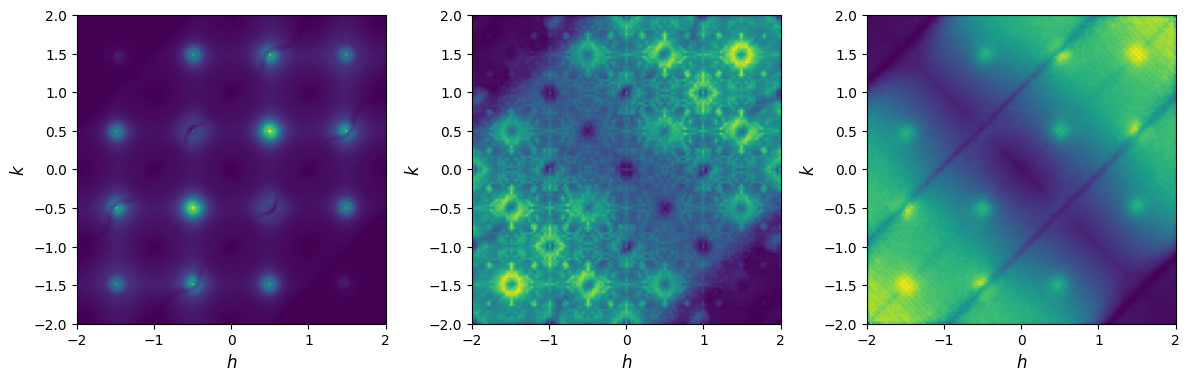

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(s_pred_masked.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[1]
ax.imshow(mask_pred.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)


ax = axes[2]
ax.imshow((neutron_exp.Sqw.cpu().numpy().sum(-1).sum(-1)).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()


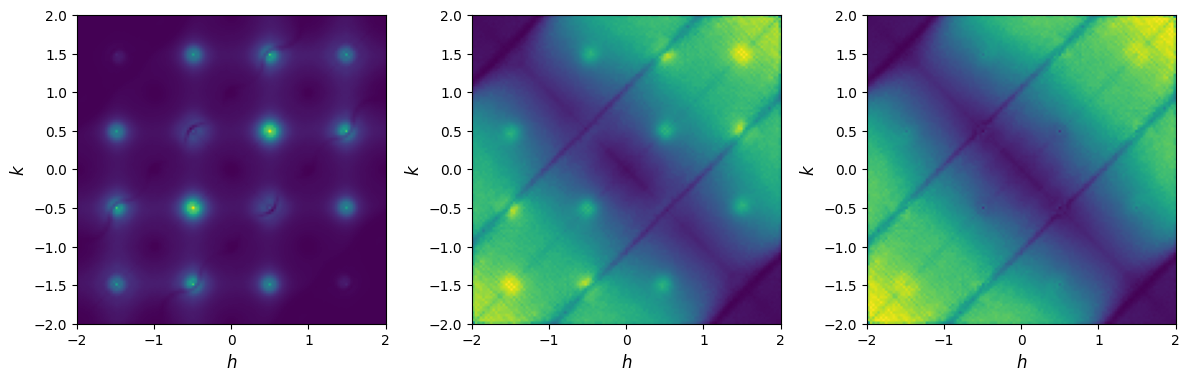

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(s_pred_masked.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[1]
ax.imshow((neutron_exp.Sqw.cpu().numpy().sum(-1).sum(-1)).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)


ax = axes[2]
ax.imshow((neutron_exp.Sqw.cpu().numpy().sum(-1).sum(-1)).T - 250 * s_pred_masked.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()

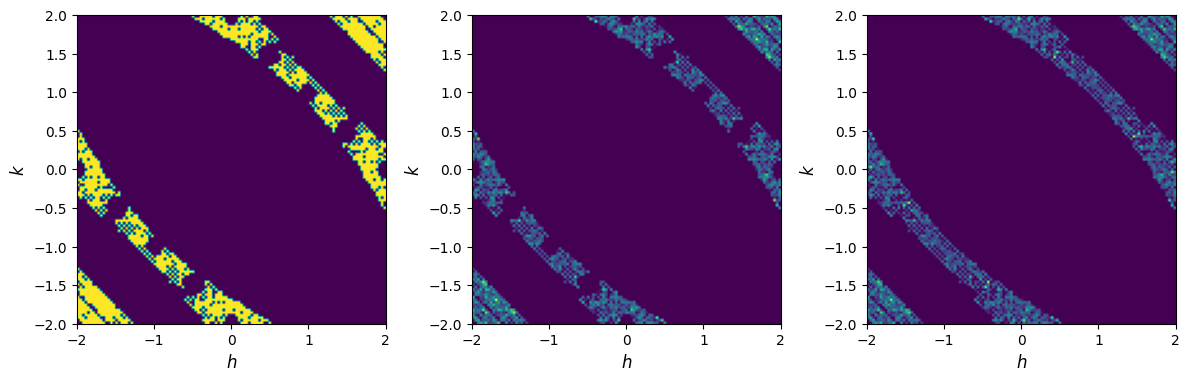

In [12]:
# background is those where experiment coverage is available (first)
# while no magnetic signal is present (second)
mask_background = (neutron_exp.Sqw.cpu().numpy() > 1e-10) * (s_pred <= 1e-4*s_pred.max())

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(mask_background[...,0,5].T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)
ax = axes[1]
ax.imshow((neutron_exp.Sqw.cpu().numpy() * mask_background)[...,0,5].T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)
ax = axes[2]
ax.imshow((neutron_exp.Sqw.cpu().numpy())[...,0,5].T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()

In [13]:
hklw_grid.shape

torch.Size([121, 121, 30, 66, 4])

In [14]:
mask_background.shape

(121, 121, 30, 66)

In [15]:
data['S'][mask_background].shape

torch.Size([5265405])

In [27]:
from inxss.dataset import BackgroundDataset
from inxss.specnet import BackgroundNeuralRepr
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [35]:
train_idx, val_test_idx = train_test_split(np.arange(len(data['S'][mask_background])), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)


In [38]:
train_dataset = BackgroundDataset({'S': data['S'][mask_background][train_idx], 'x': hklw_grid[mask_background][train_idx]})
valid_dataset = BackgroundDataset({'S': data['S'][mask_background][val_idx],   'x': hklw_grid[mask_background][val_idx]})

In [41]:
train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)
val_loader   = DataLoader(valid_dataset, batch_size=10000, shuffle=False)

In [42]:
background_net = BackgroundNeuralRepr()

In [43]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
    save_on_train_epoch_end=False, save_last=True, save_top_k=1, monitor="val_loss"
)

logger = TensorBoardLogger(save_dir='/pscratch/sd/z/zhantao/inxs_steering/background_networks')

trainer = L.Trainer(
    max_epochs=10000, accelerator="gpu",
    callbacks=[TQDMProgressBar(refresh_rate=10), checkpoint_callback],
    logger=logger, log_every_n_steps=1, devices=1,
    enable_checkpointing=True,
    default_root_dir='/pscratch/sd/z/zhantao/inxs_steering/background_networks'
)

trainer.fit(background_net, train_loader, val_loader)

/pscratch/sd/z/zhantao/conda/inxs/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /pscratch/sd/z/zhantao/conda/inxs/lib/python3.9/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/pscratch/sd/z/zhantao/conda/inxs/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /pscratch/sd/z/zhantao/conda/inxs/lib/python3.9/site ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/pscratch/sd/z/zhantao/conda/inxs/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/pscratch/sd/z/zhantao/conda/inxs/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 95:  38%|███▊      | 160/422 [00:22<00:36,  7.20it/s, v_num=0]

/pscratch/sd/z/zhantao/conda/inxs/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


: 